In [1]:
%cd /Users/govindrnair/ParamEst_Glio

/Users/govindrnair/ParamEst_Glio


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import scipy


#### Solving the forward problem

In [ ]:
# Defining spatial parameters

L = 2*np.pi #spatial scale
N_grid = 128 #grid size

del_grid = L/N_grid #discretization

x_domain, y_domain = np.linspace(0,L,N_grid), np.linspace(0,L,N_grid)

X_mesh, Y_mesh = np.meshgrid(x_domain,y_domain)


[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.0494739  0.0494739  0.0494739  ... 0.0494739  0.0494739  0.0494739 ]
 [0.0989478  0.0989478  0.0989478  ... 0.0989478  0.0989478  0.0989478 ]
 ...
 [6.18423751 6.18423751 6.18423751 ... 6.18423751 6.18423751 6.18423751]
 [6.23371141 6.23371141 6.23371141 ... 6.23371141 6.23371141 6.23371141]
 [6.28318531 6.28318531 6.28318531 ... 6.28318531 6.28318531 6.28318531]]


In [55]:
#defining ground truth

#reaction-diffusion paraameters
k_true = 1e-1
rho_true = 3

#initial_condition
p_true = np.zeros(N_grid)
p_list = [1,0.5,1,0.1,1,1]


(128, 128)


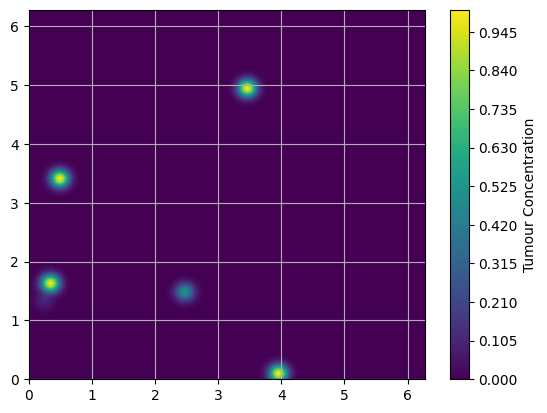

In [57]:
#gaussian basis functions

m = 6 #number of seed locations
sigma = 2*del_grid #width parameter

def gauss_basis_func(x_val,y_val,x_i,y_i,sigma):
    """
    x_val, y_val : scalar coordinates
    x_i, y_i     : center coordinates
    """
    x = np.array([x_val,y_val])
    xi = np.array([x_i,y_i])
    # use squared Euclidean distance in Gaussian exponent
    exp_factor = -np.linalg.norm((x-xi), ord=2)**2 / (2*(sigma**2))
    return np.exp(exp_factor)

# vectorize and ensure float output
vectorized_func = np.vectorize(gauss_basis_func, otypes=[float])

seed_list = [[10,69],[50,30],[70,100],[5,27],[80,2],[7,33]]

basis_func_list=[]

for seed_loc in seed_list:
    pos_x_idx, pos_y_idx = seed_loc
    # interpret seed indices as indices into the x_domain/y_domain arrays
    x_i = x_domain[pos_x_idx]
    y_i = y_domain[pos_y_idx]
    # evaluate the basis over the whole mesh
    basis_func_i = vectorized_func(X_mesh, Y_mesh, x_i, y_i, sigma)
    basis_func_list.append(basis_func_i)

init_cond=basis_func_list[0]*p_list[0]
for i in range(1,len(p_list)):
    init_cond=init_cond + (basis_func_list[i] * p_list[i])
    

print(np.shape(init_cond))

plt.contourf(X_mesh,Y_mesh,init_cond,levels=200,cmap='viridis')
plt.colorbar(label='Tumour Concentration')
plt.grid(True)
plt.show()



0.0005
0.0075
Mk min: -0.024360842903379306
max inner term:  1.0499382230124386


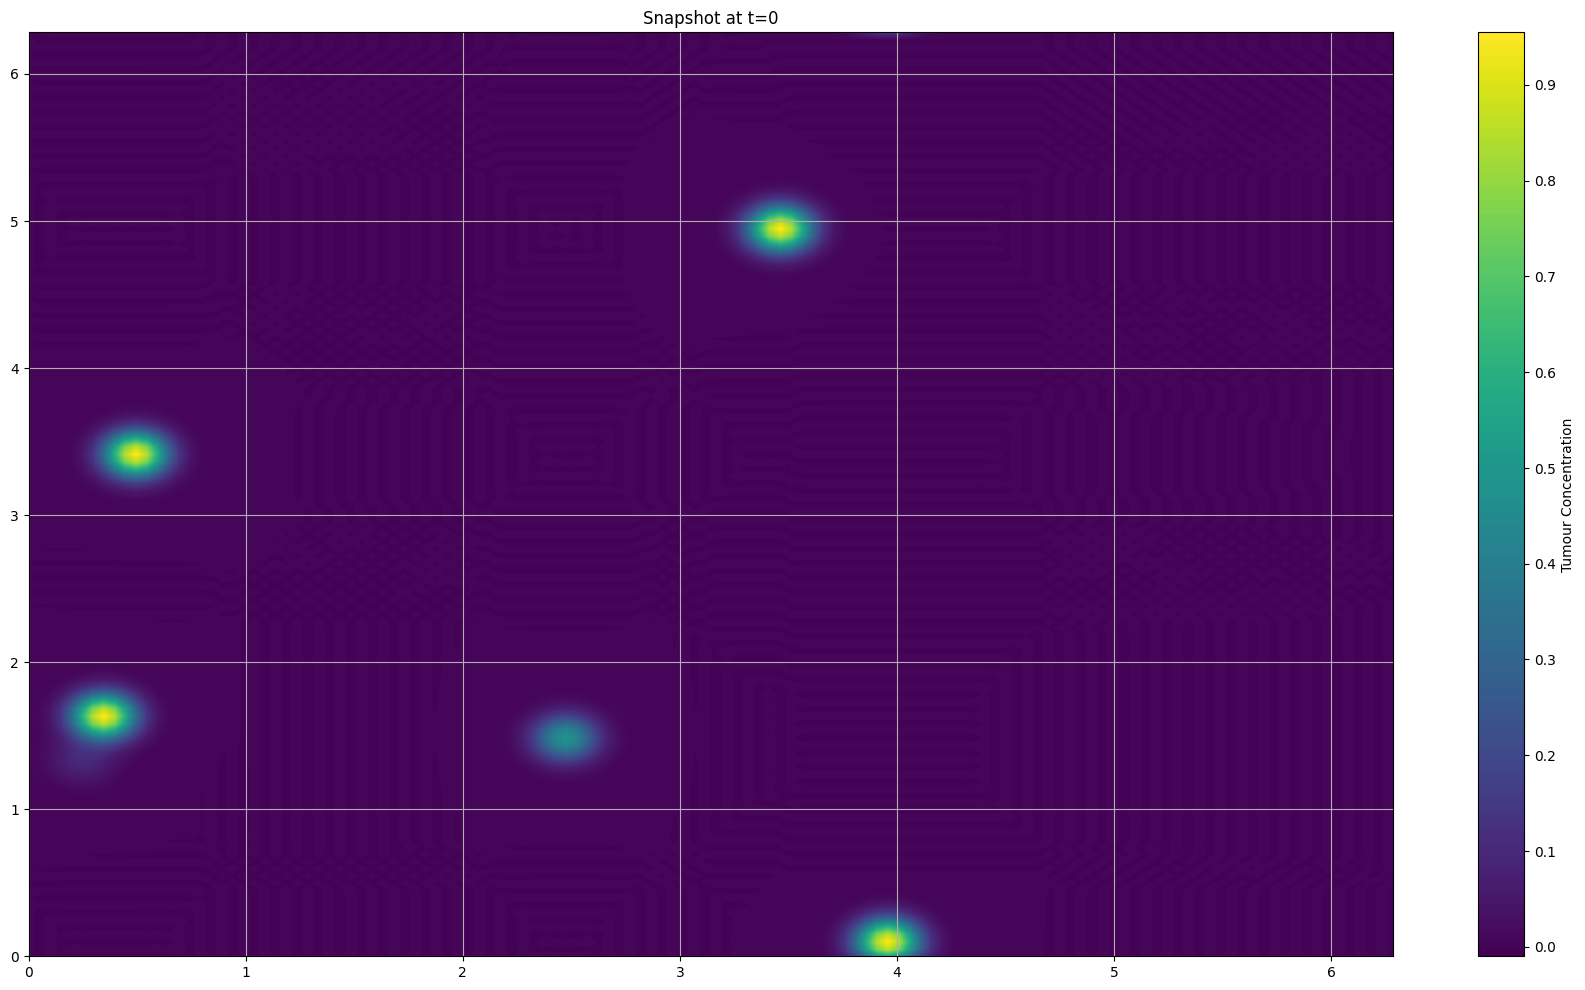

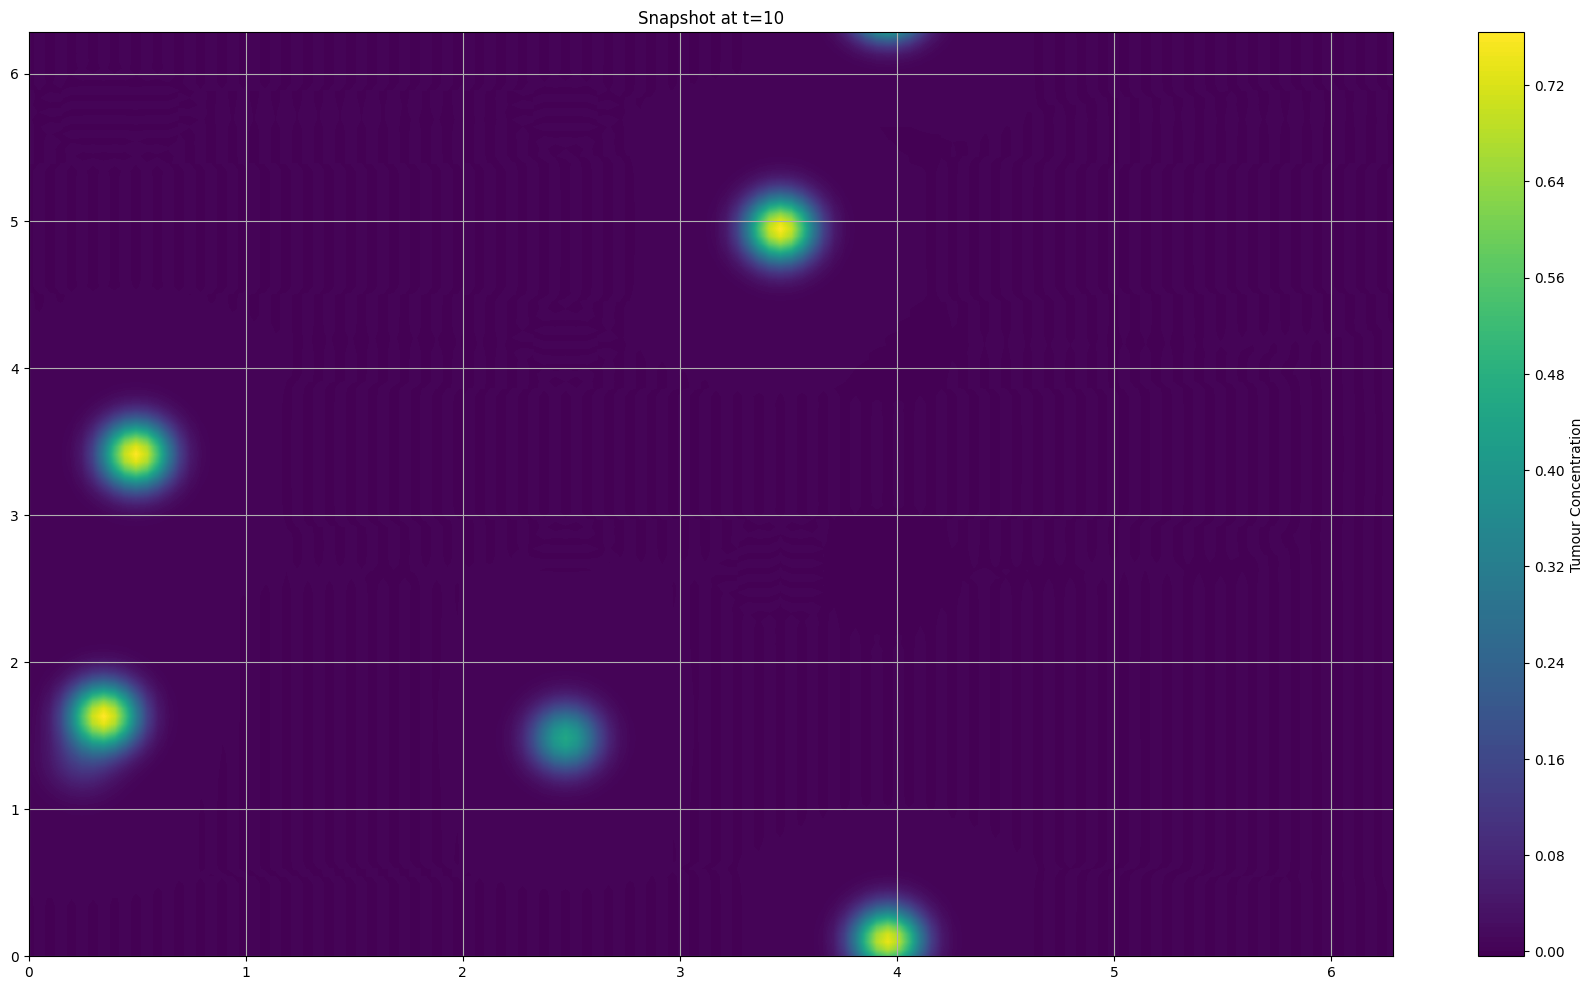

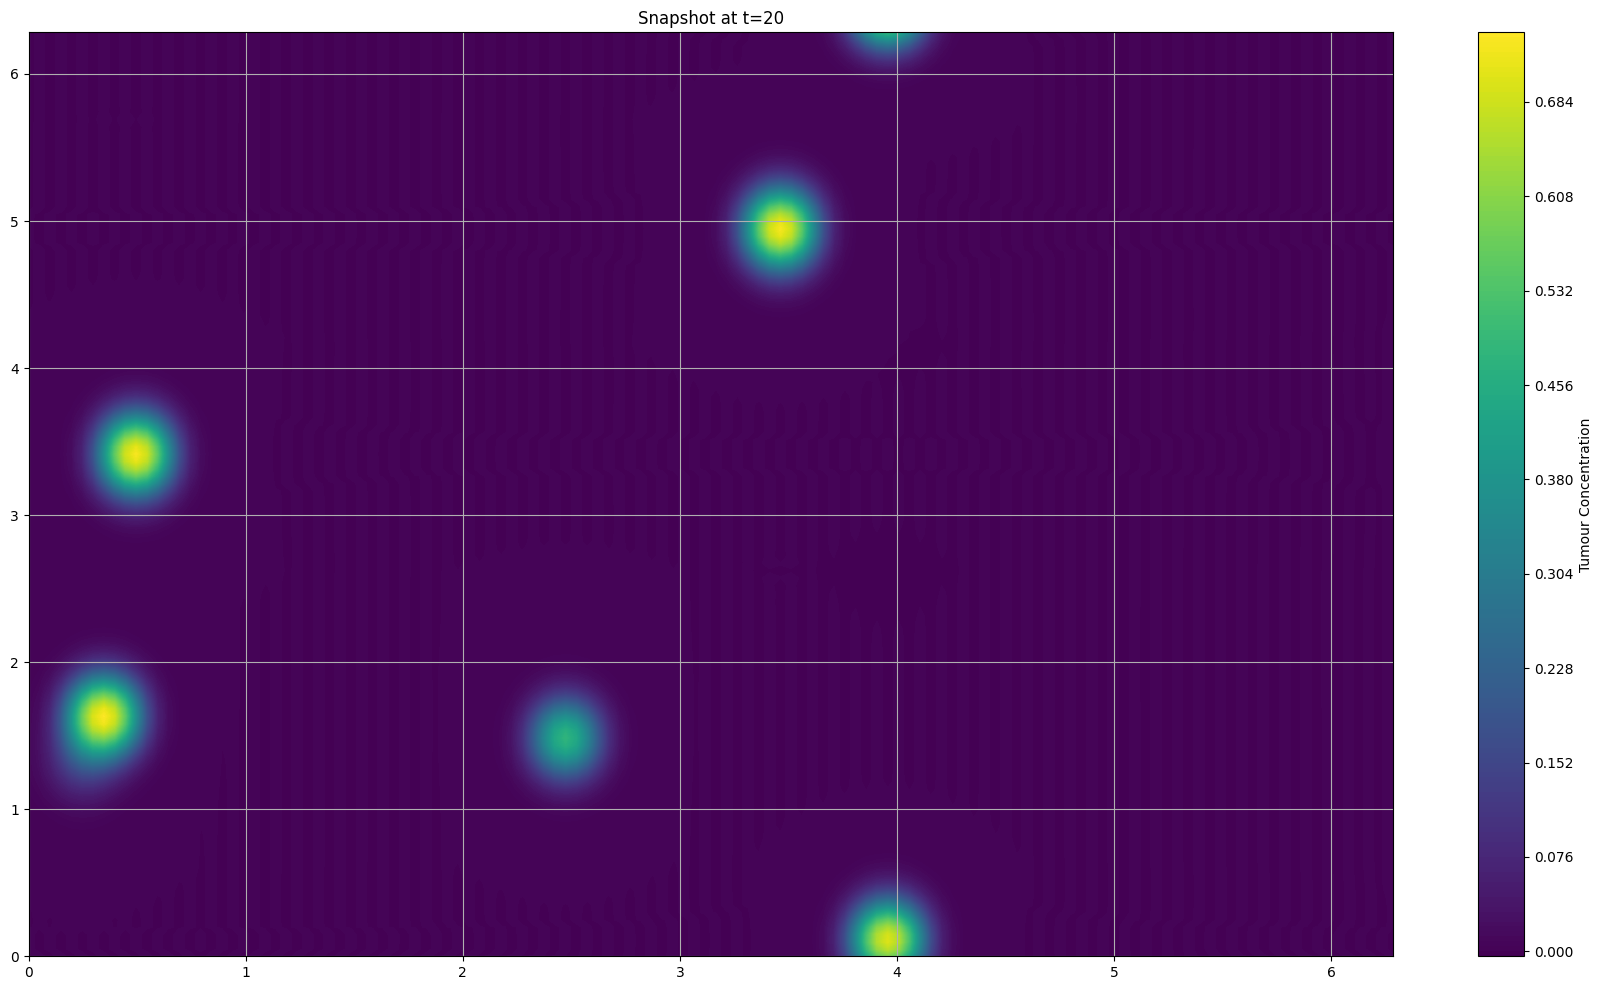

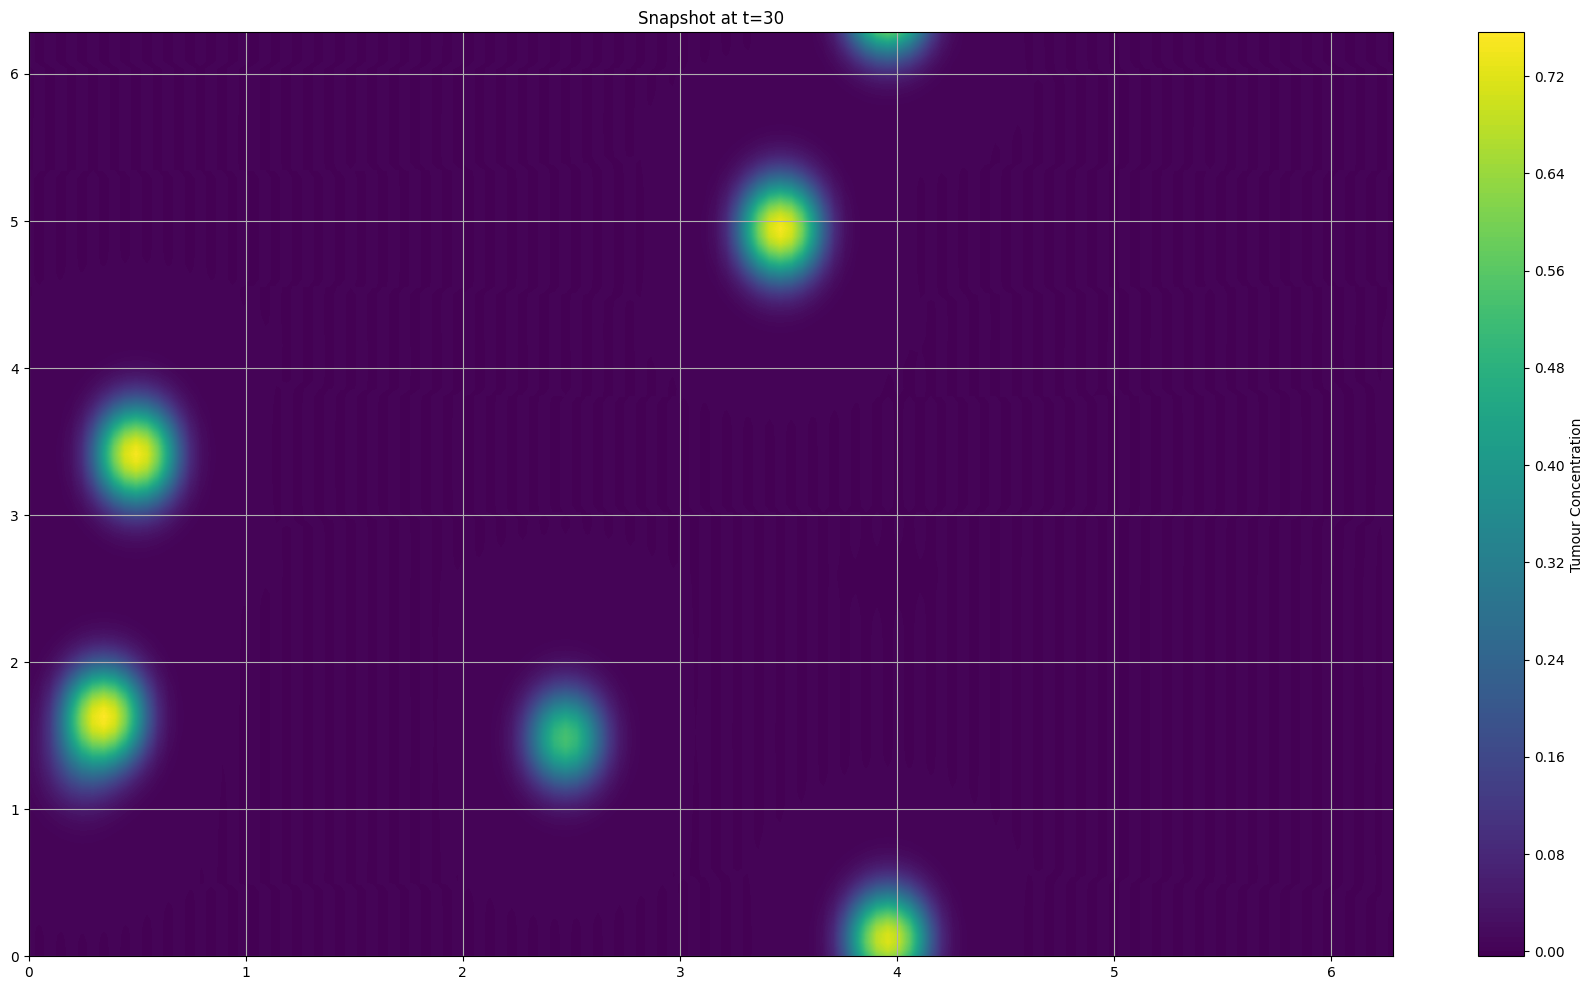

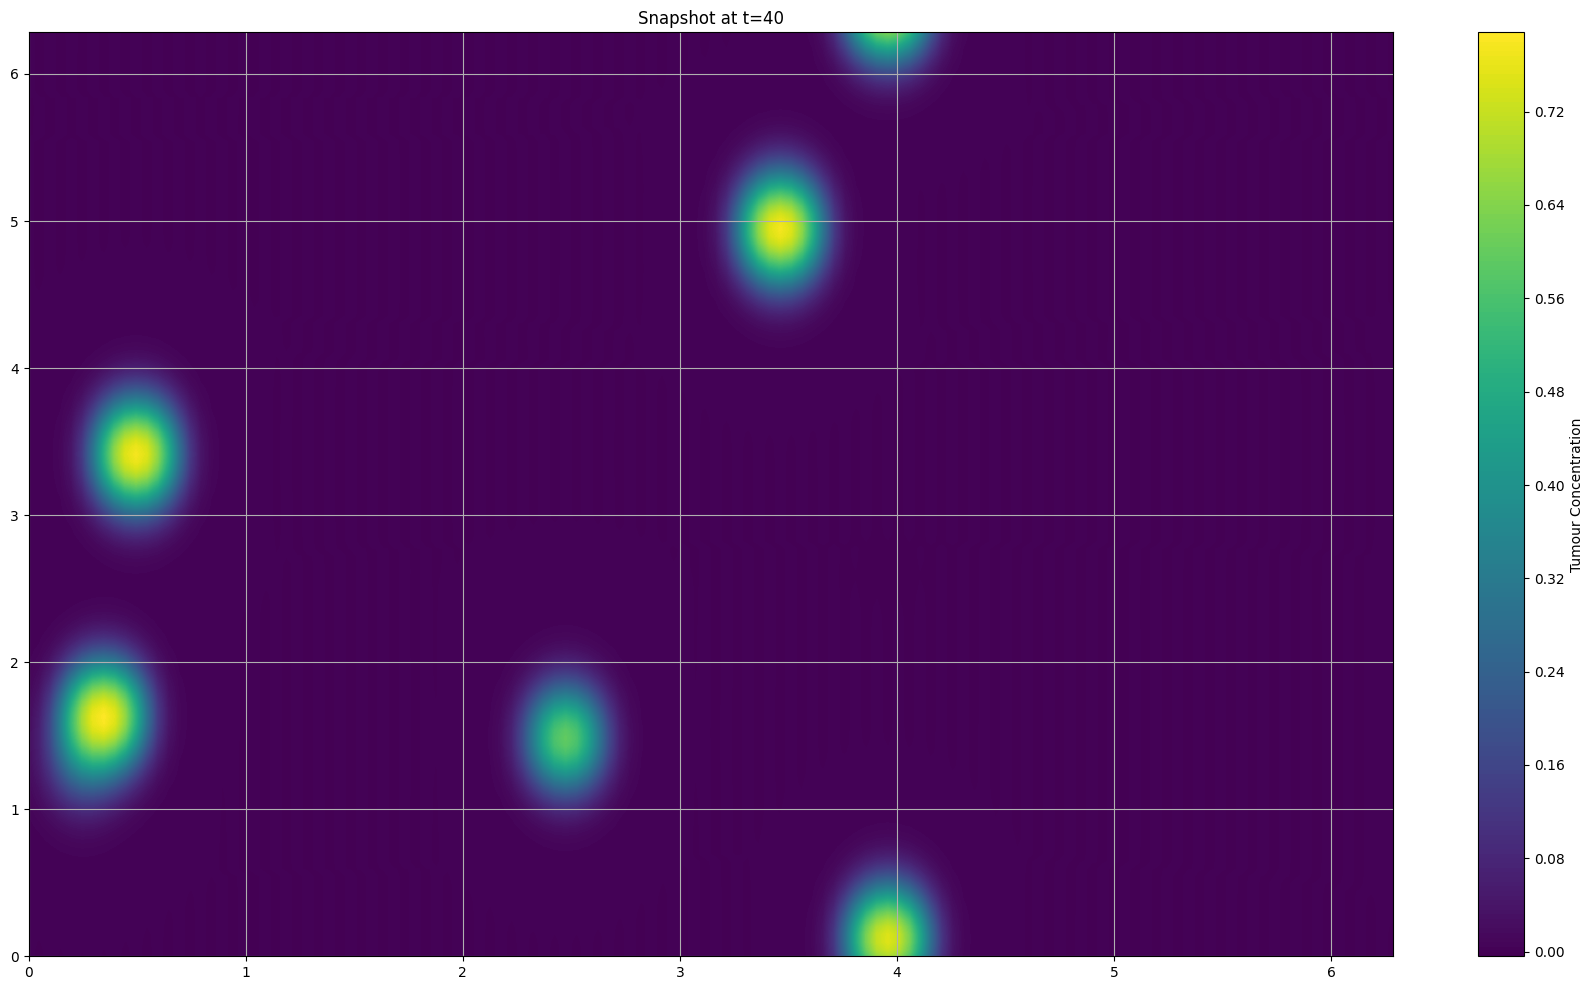

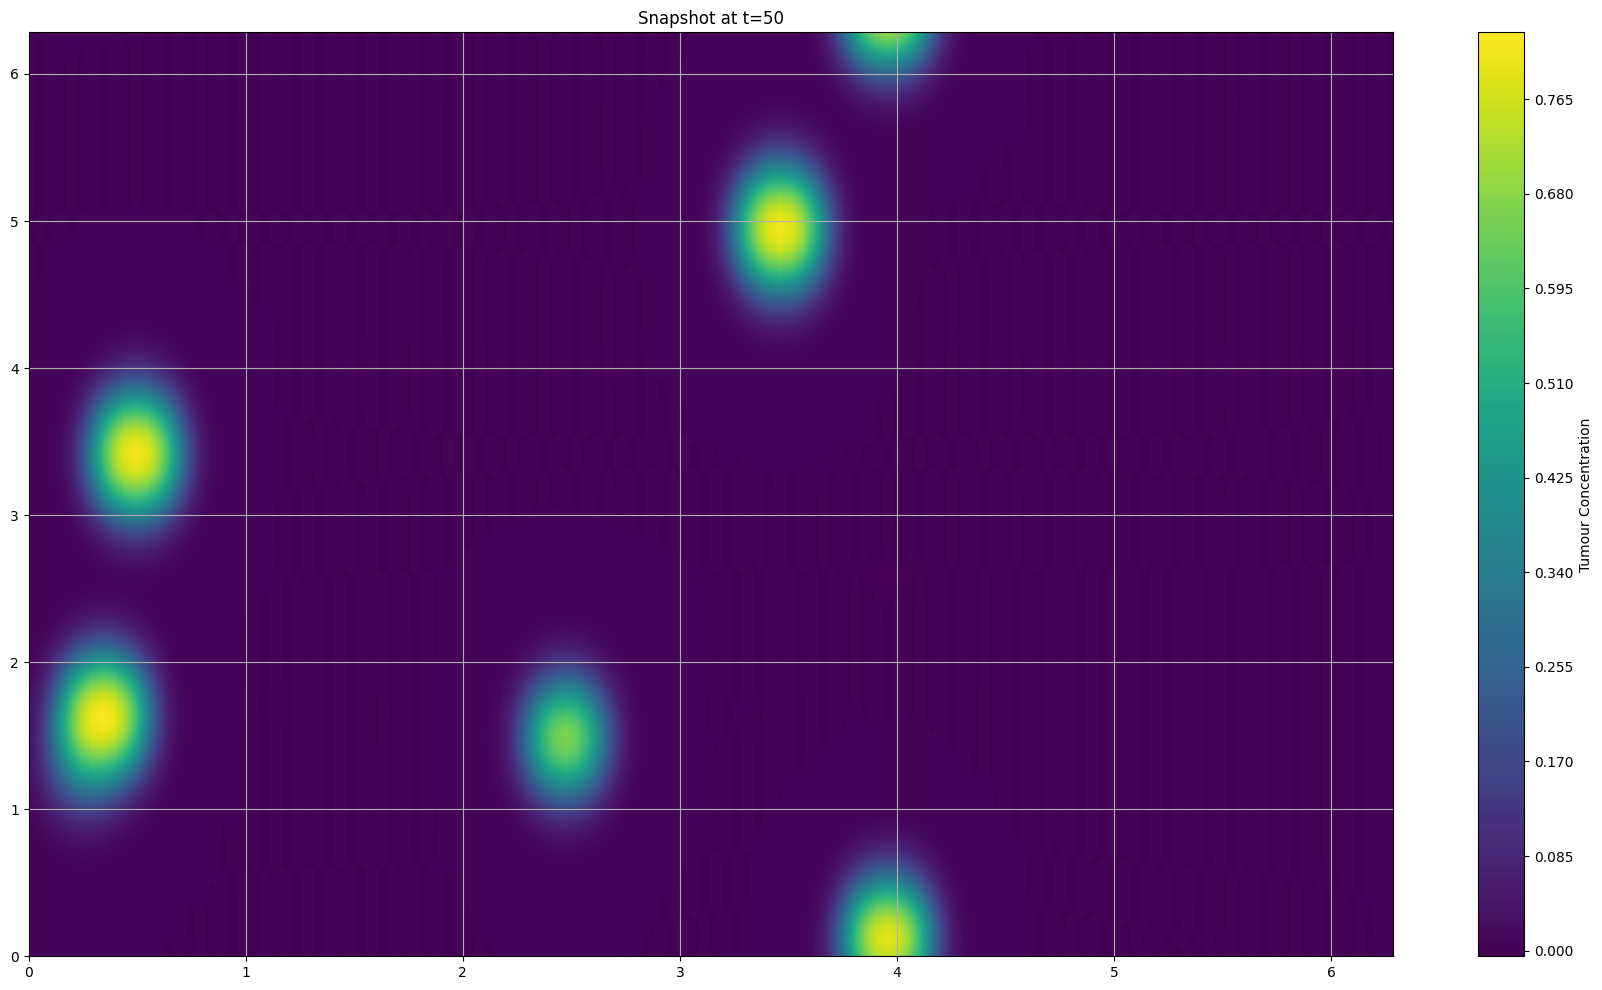

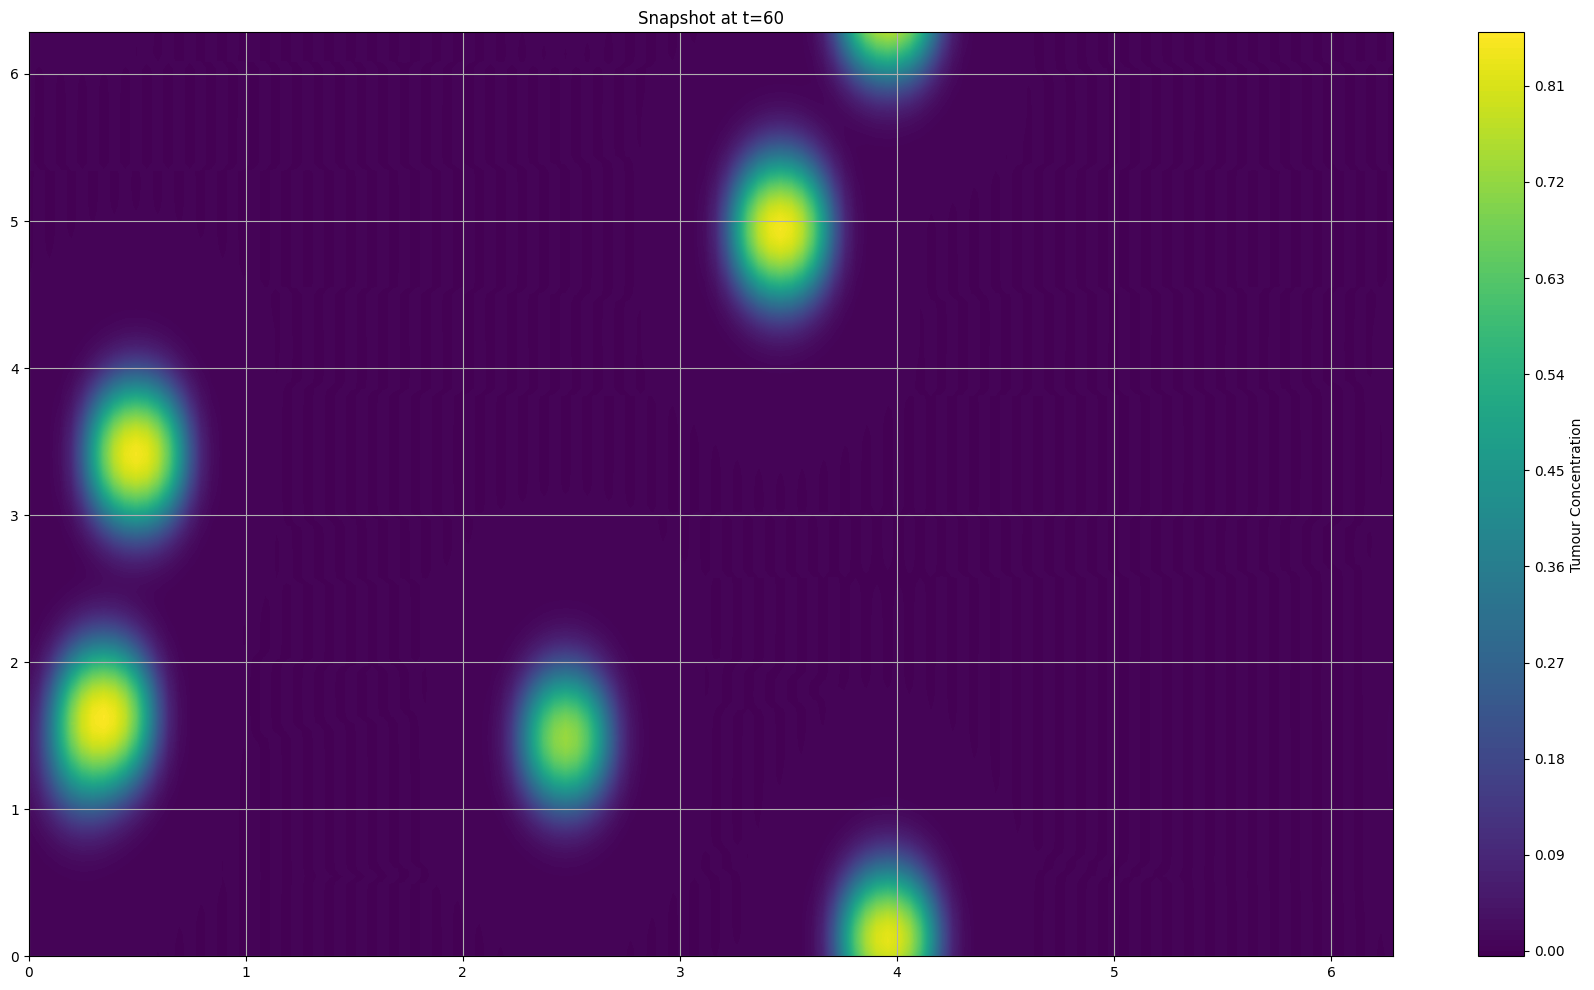

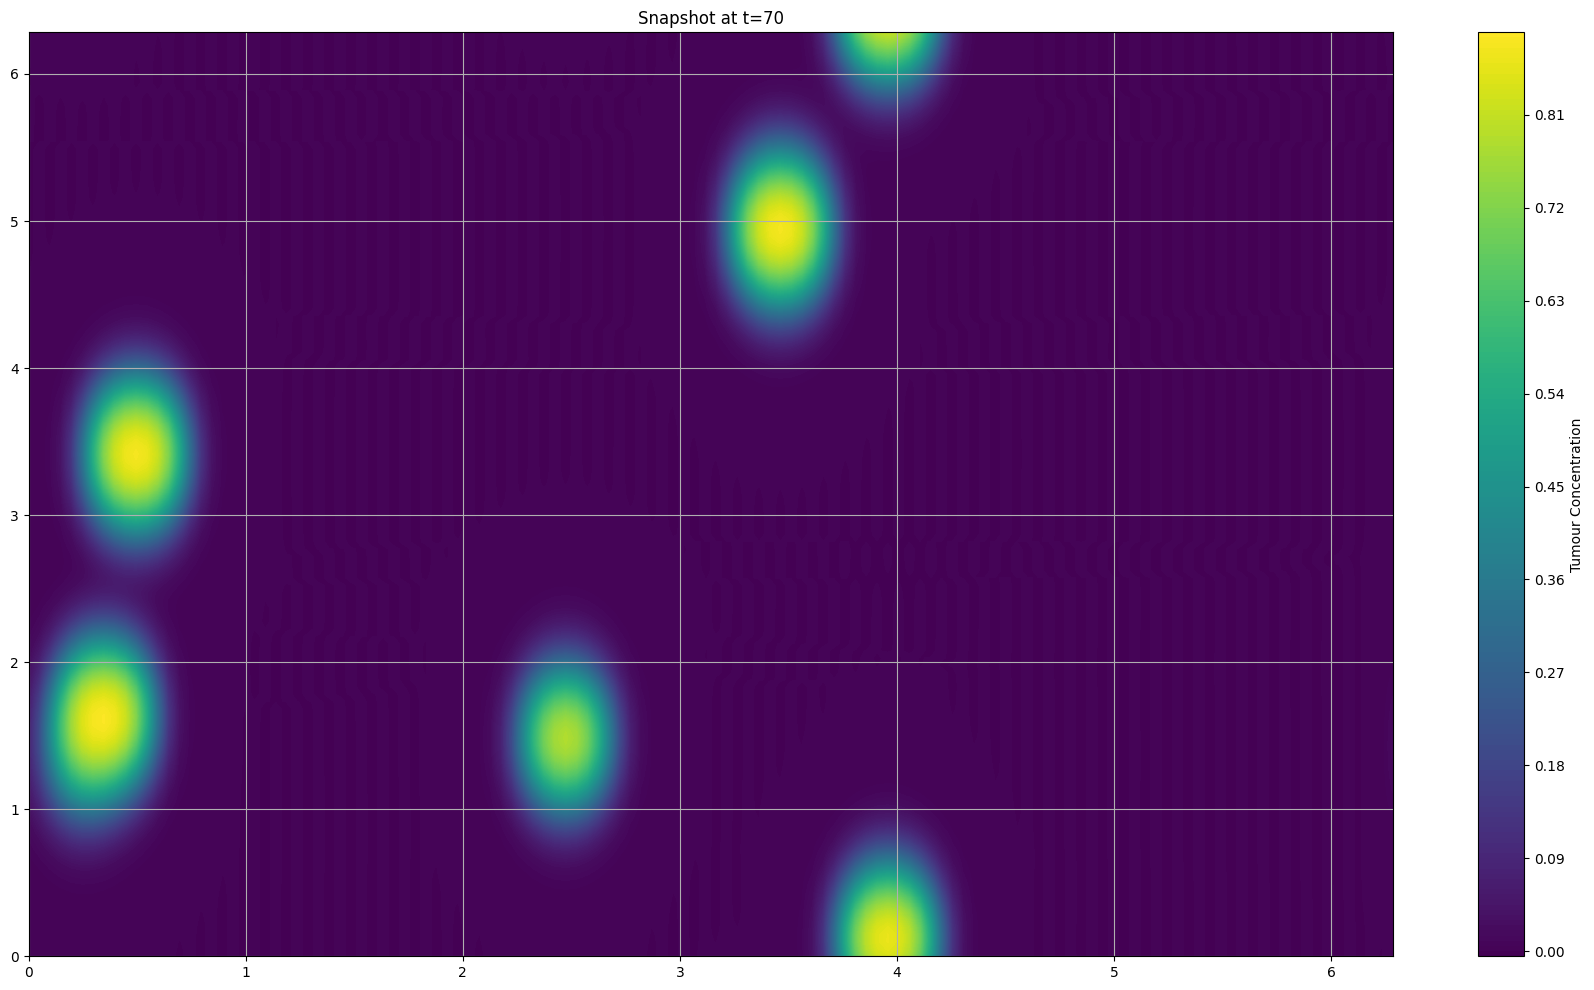

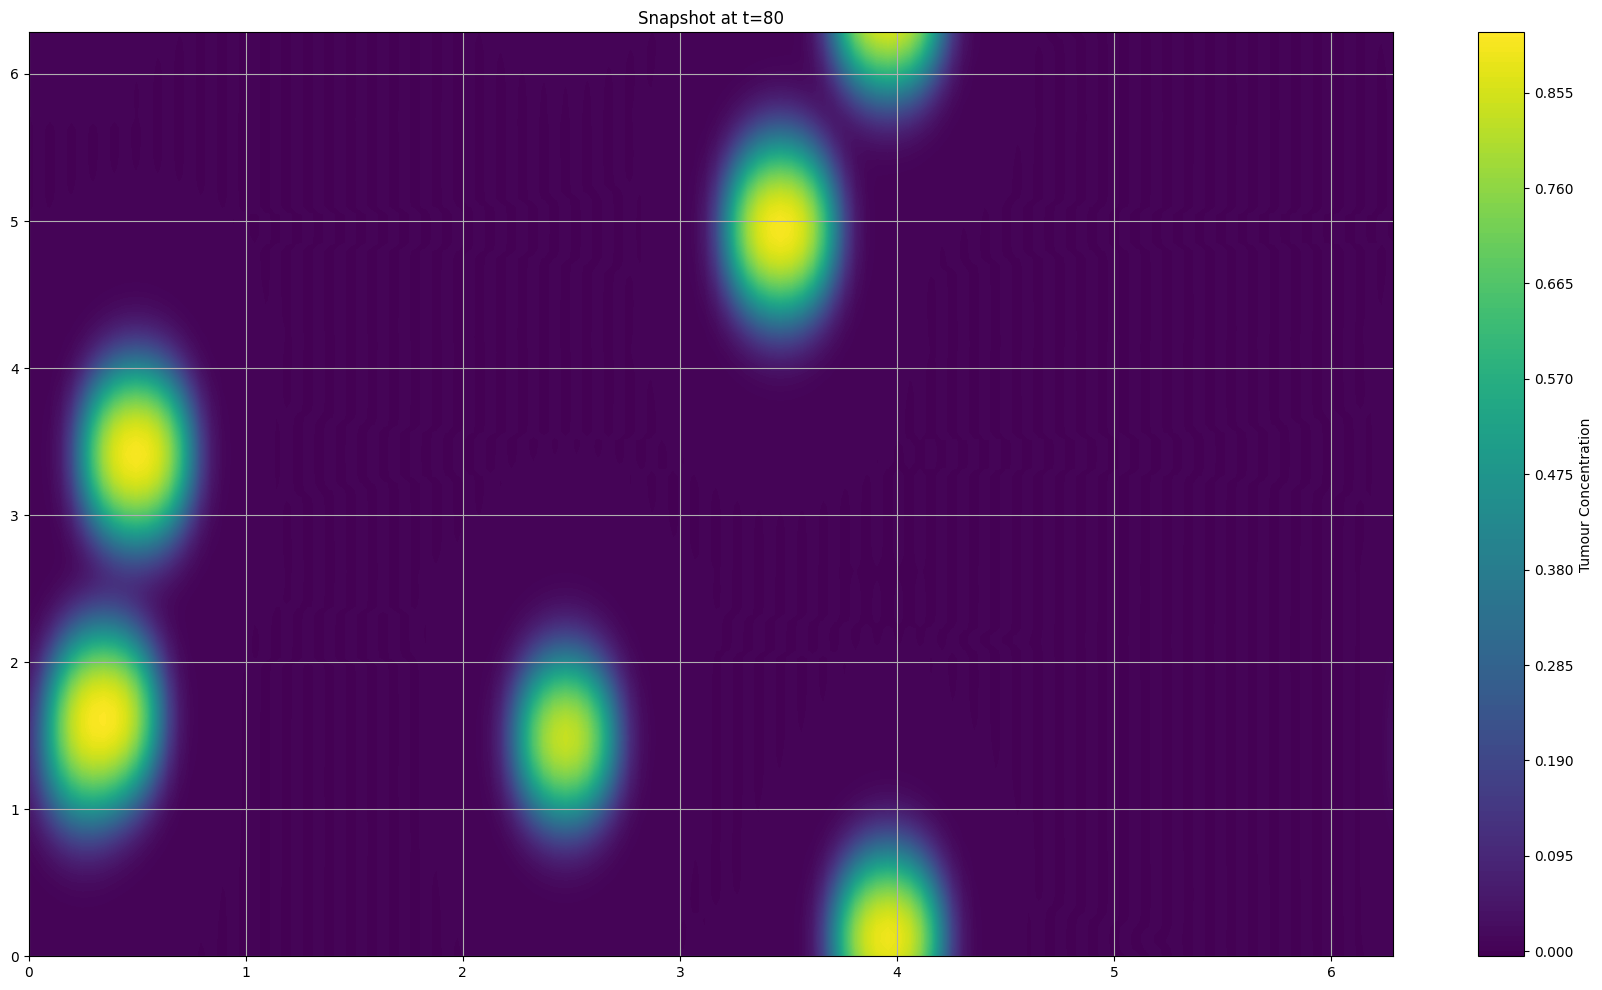

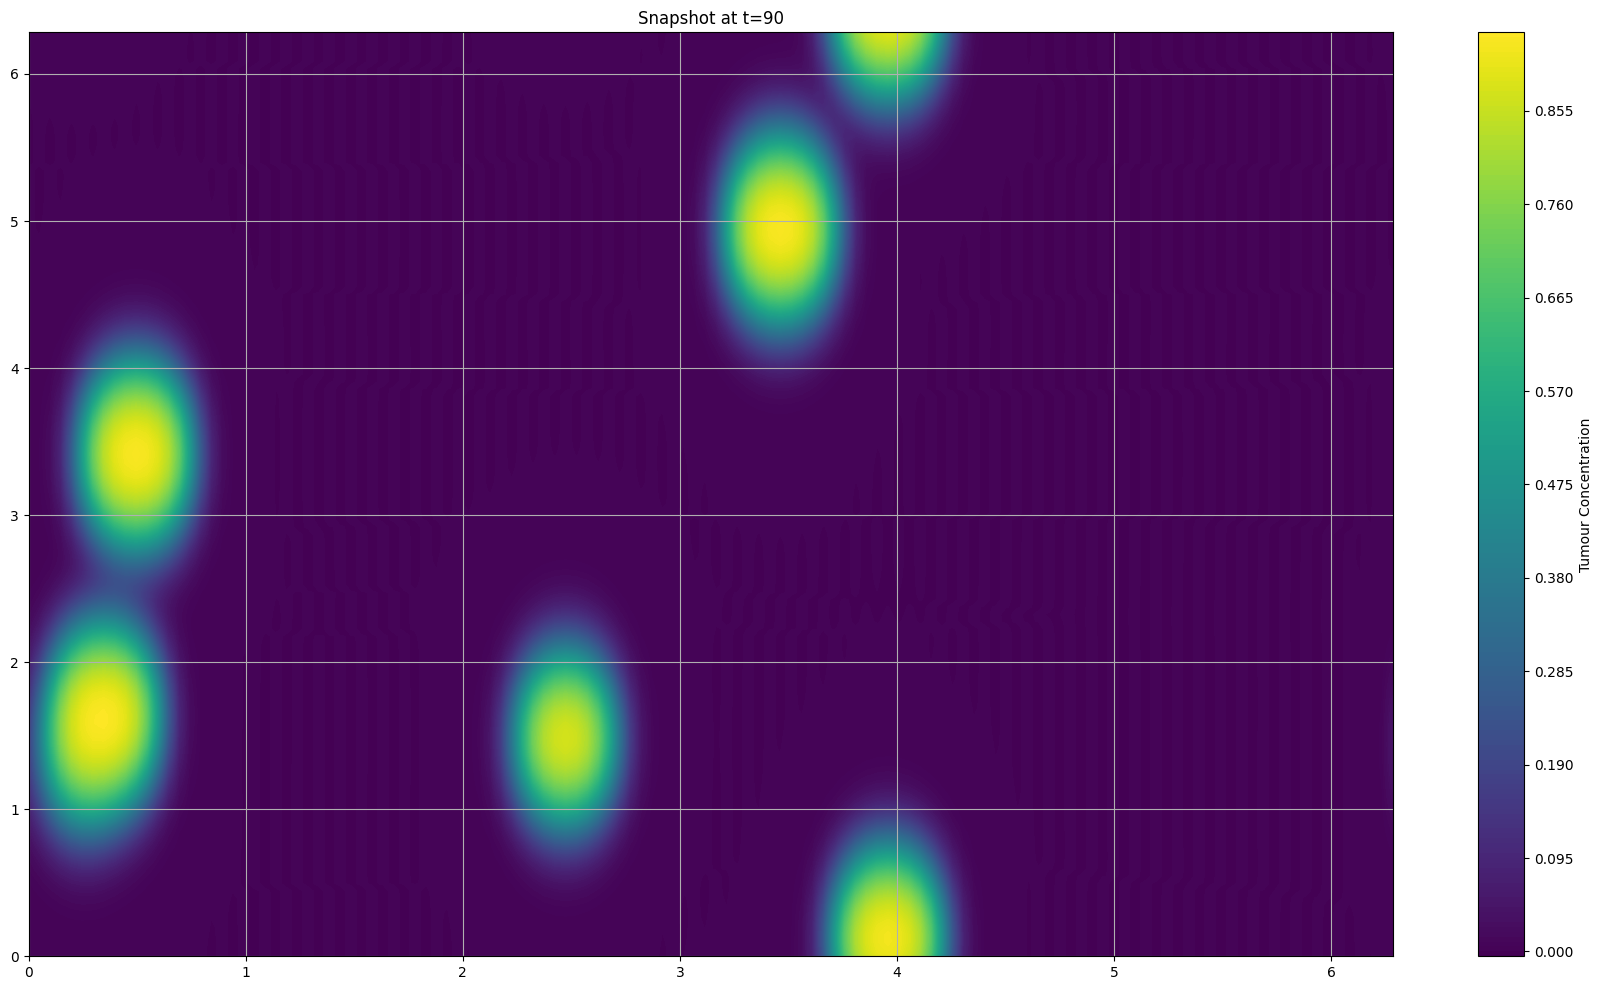

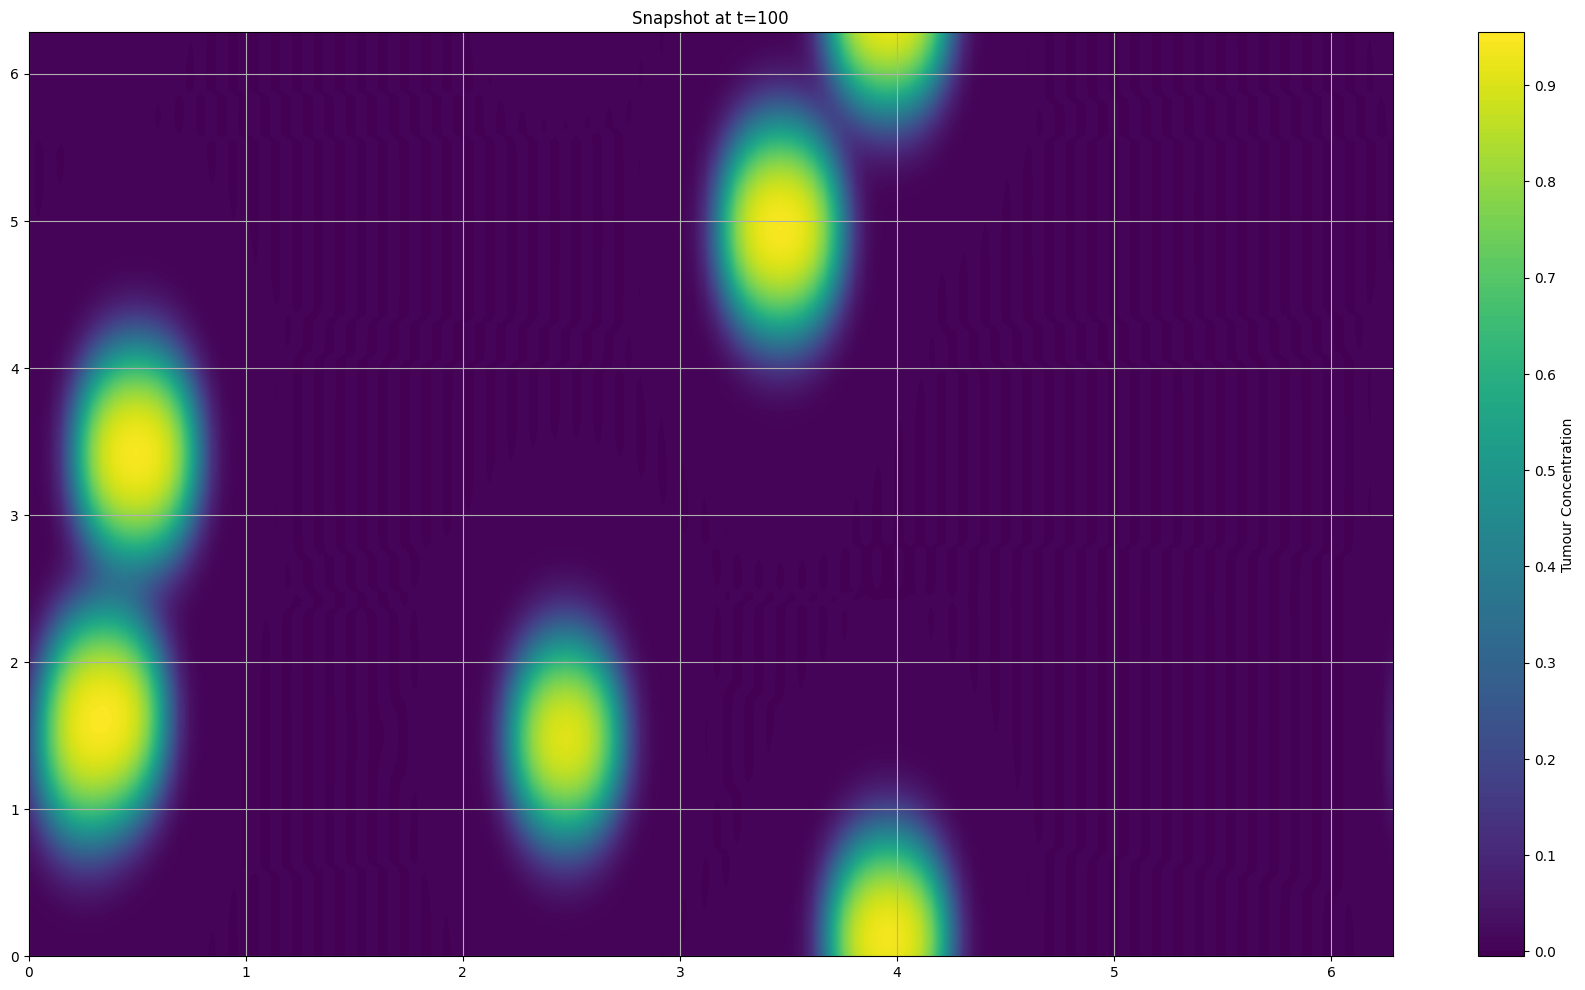

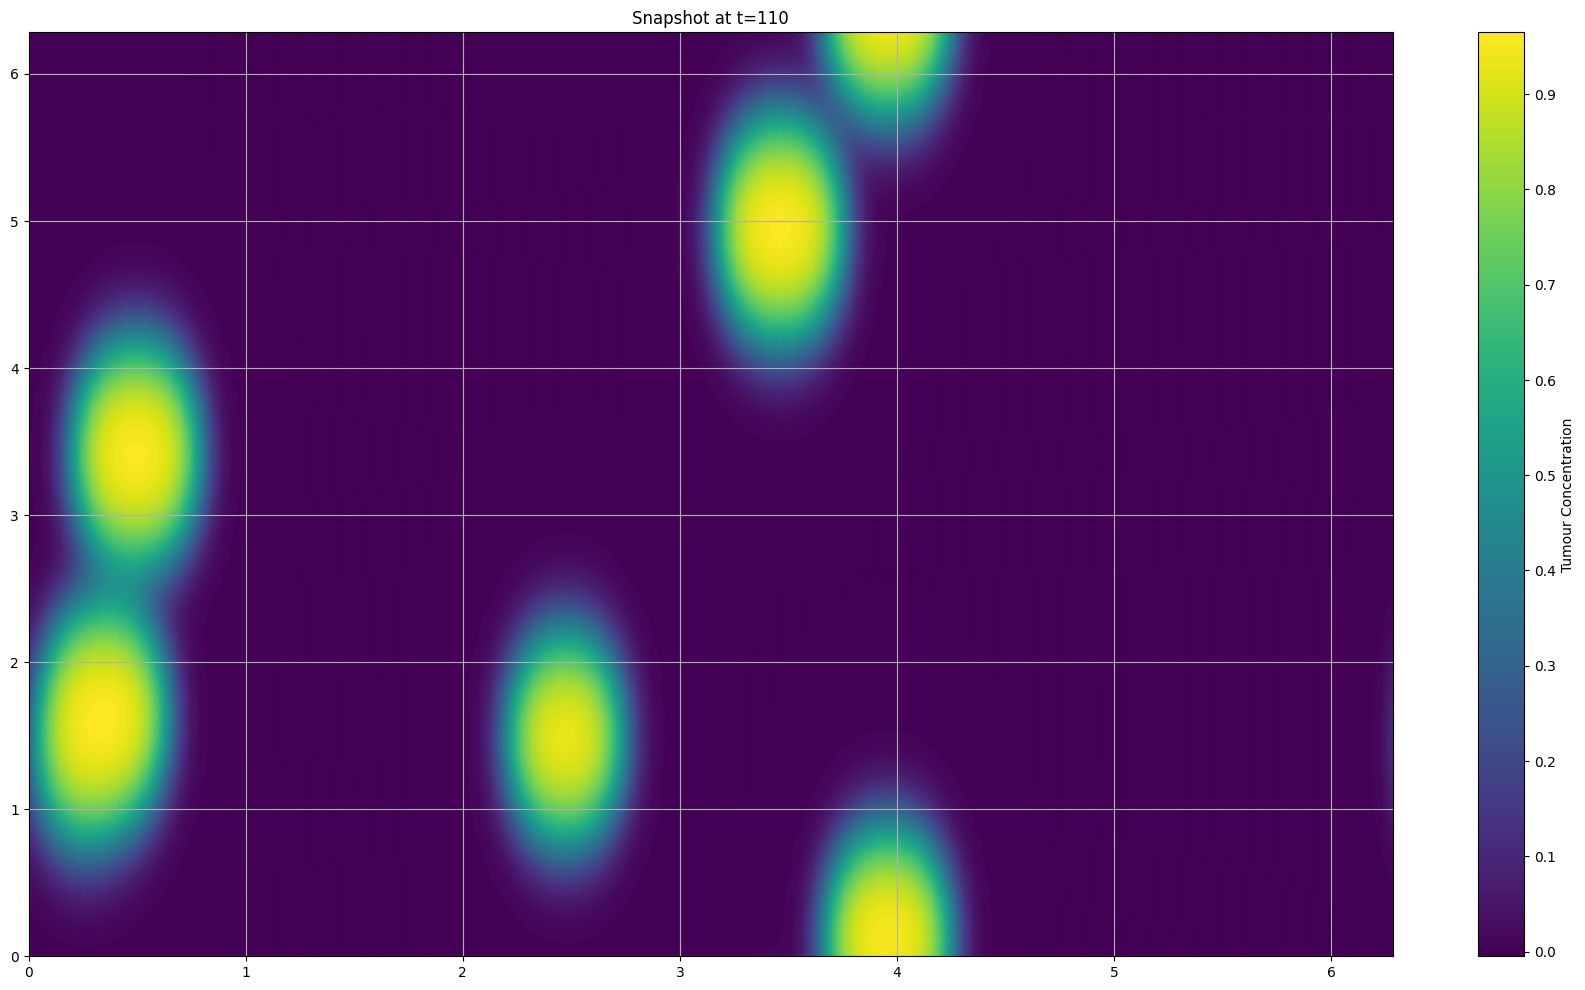

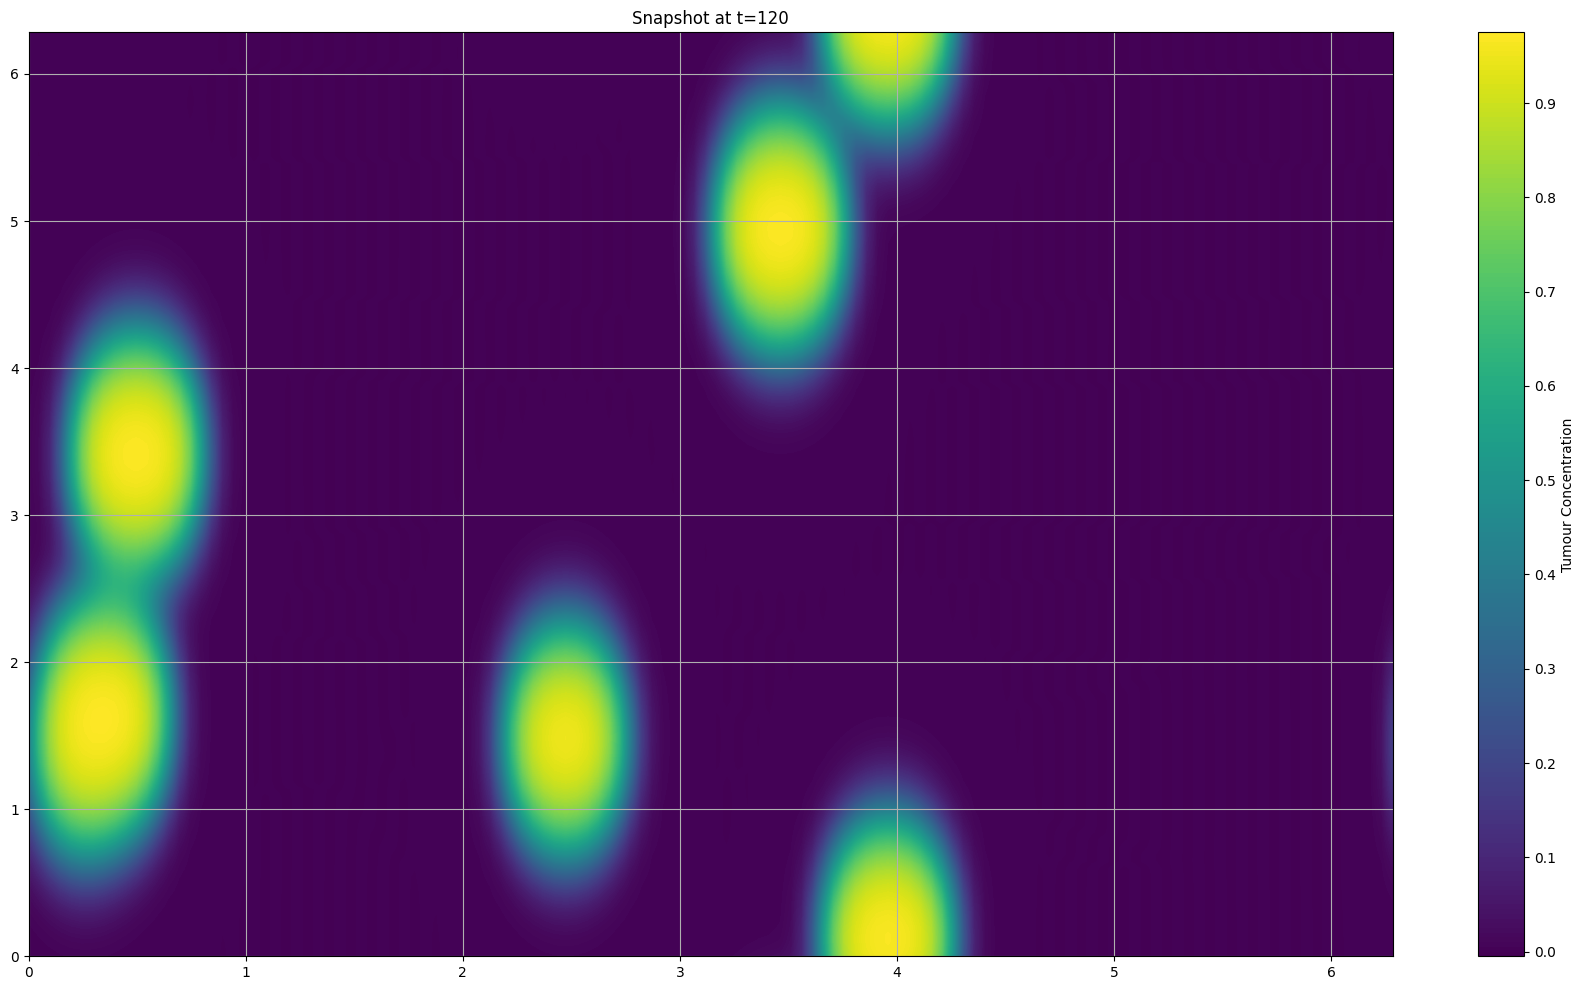

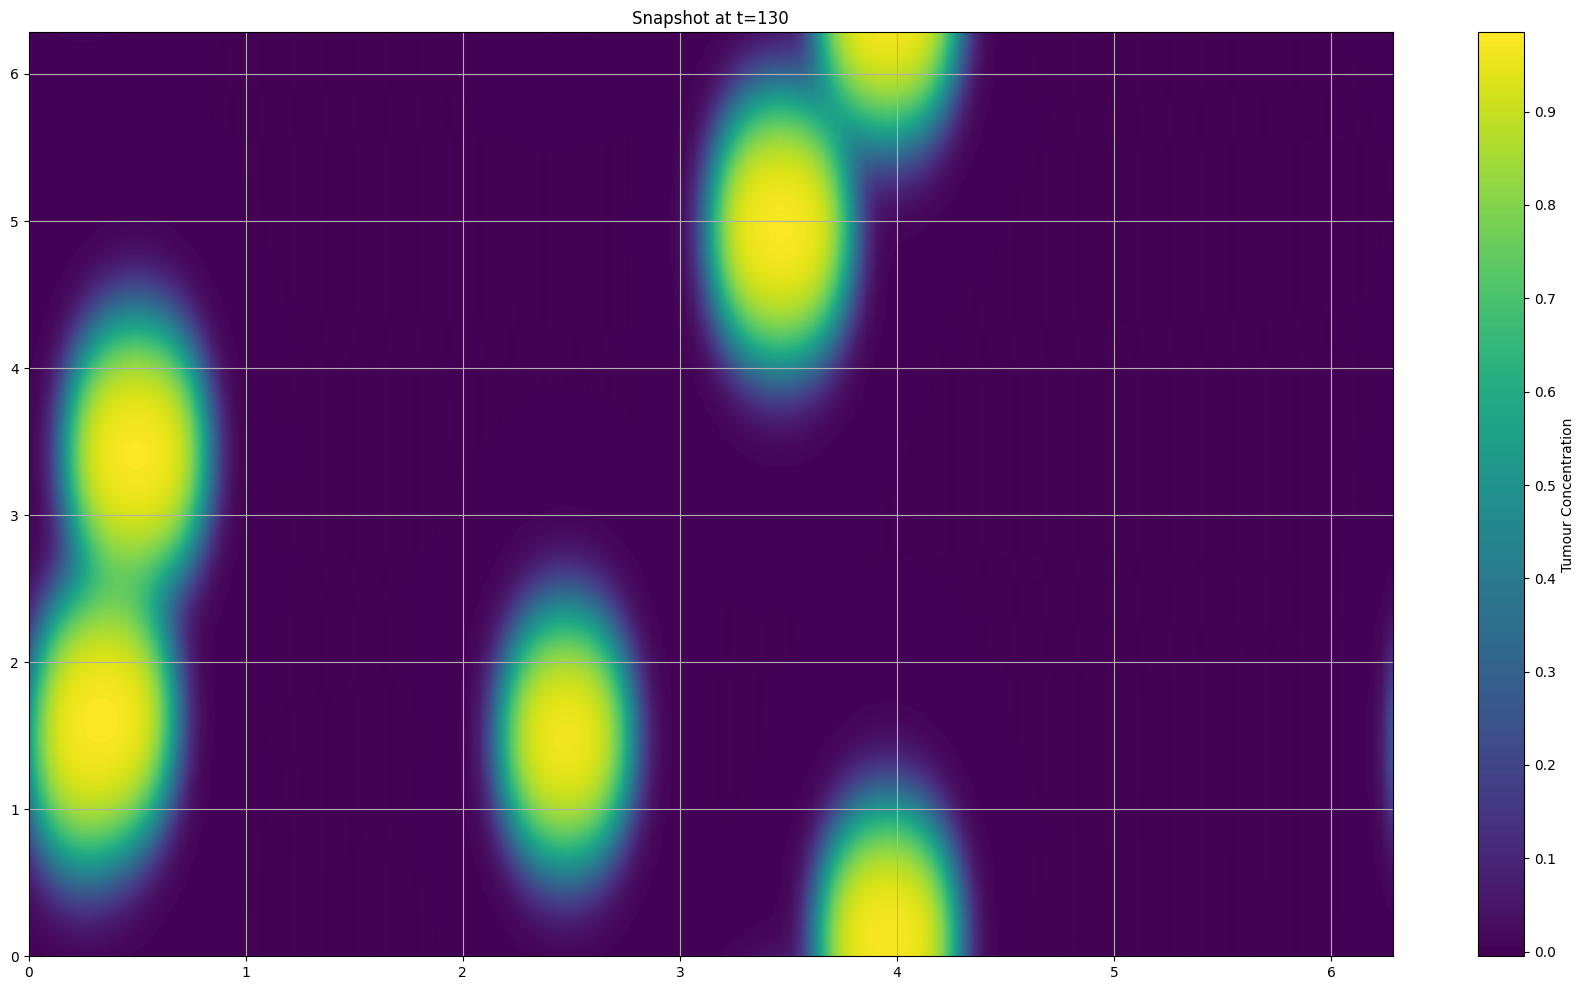

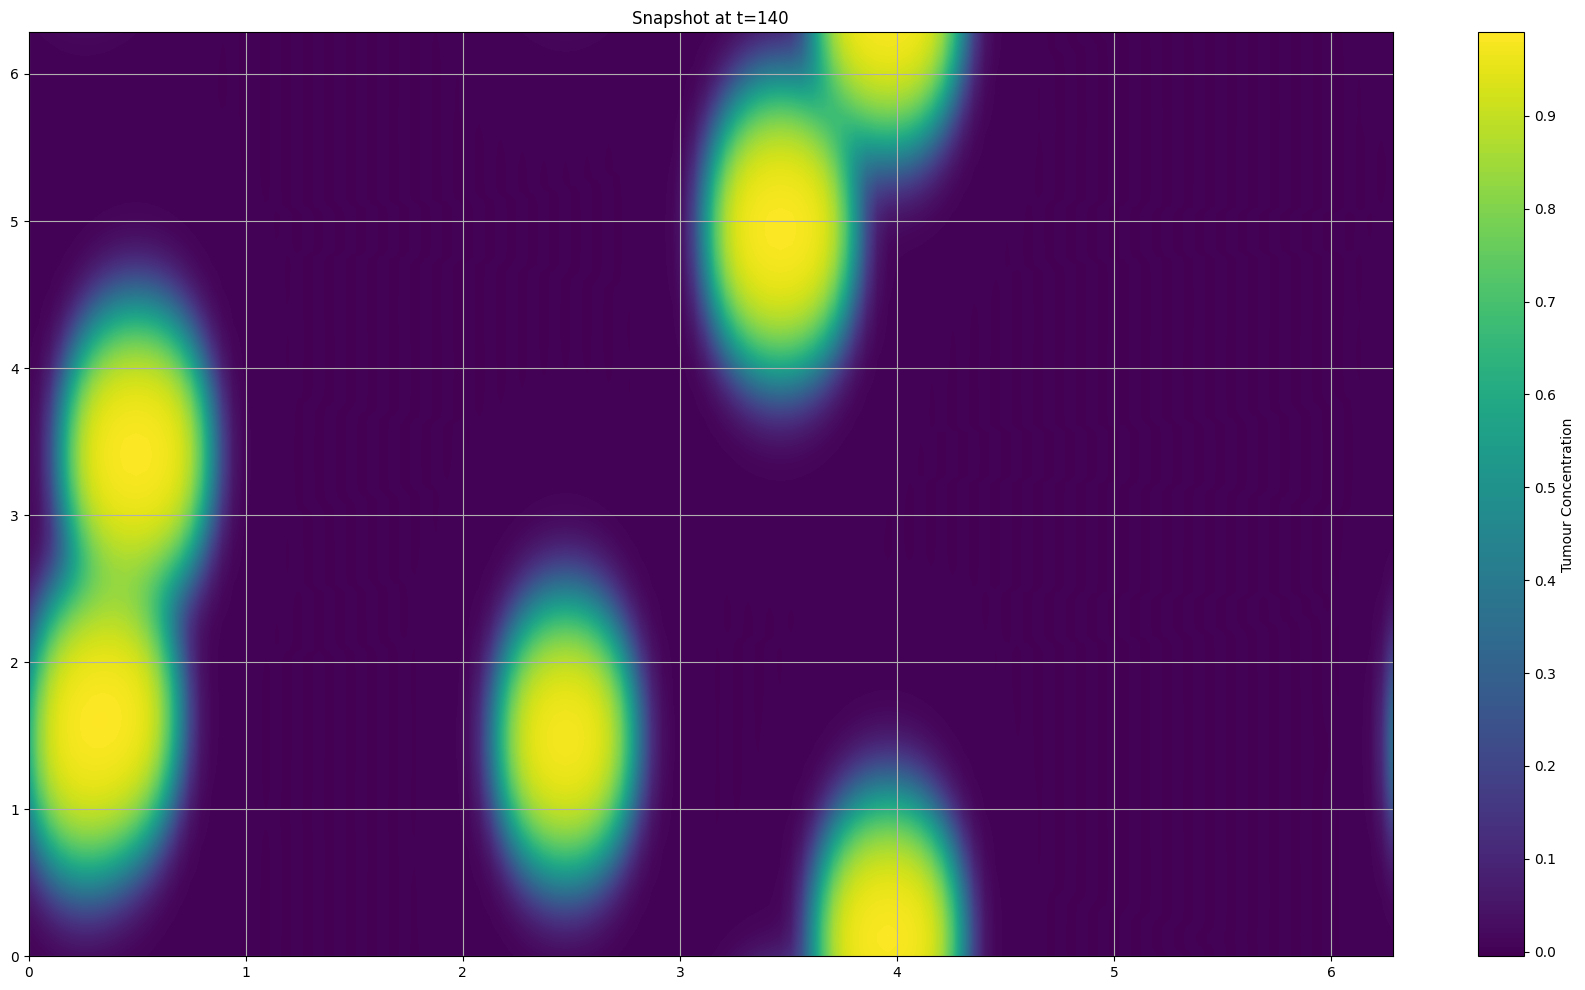

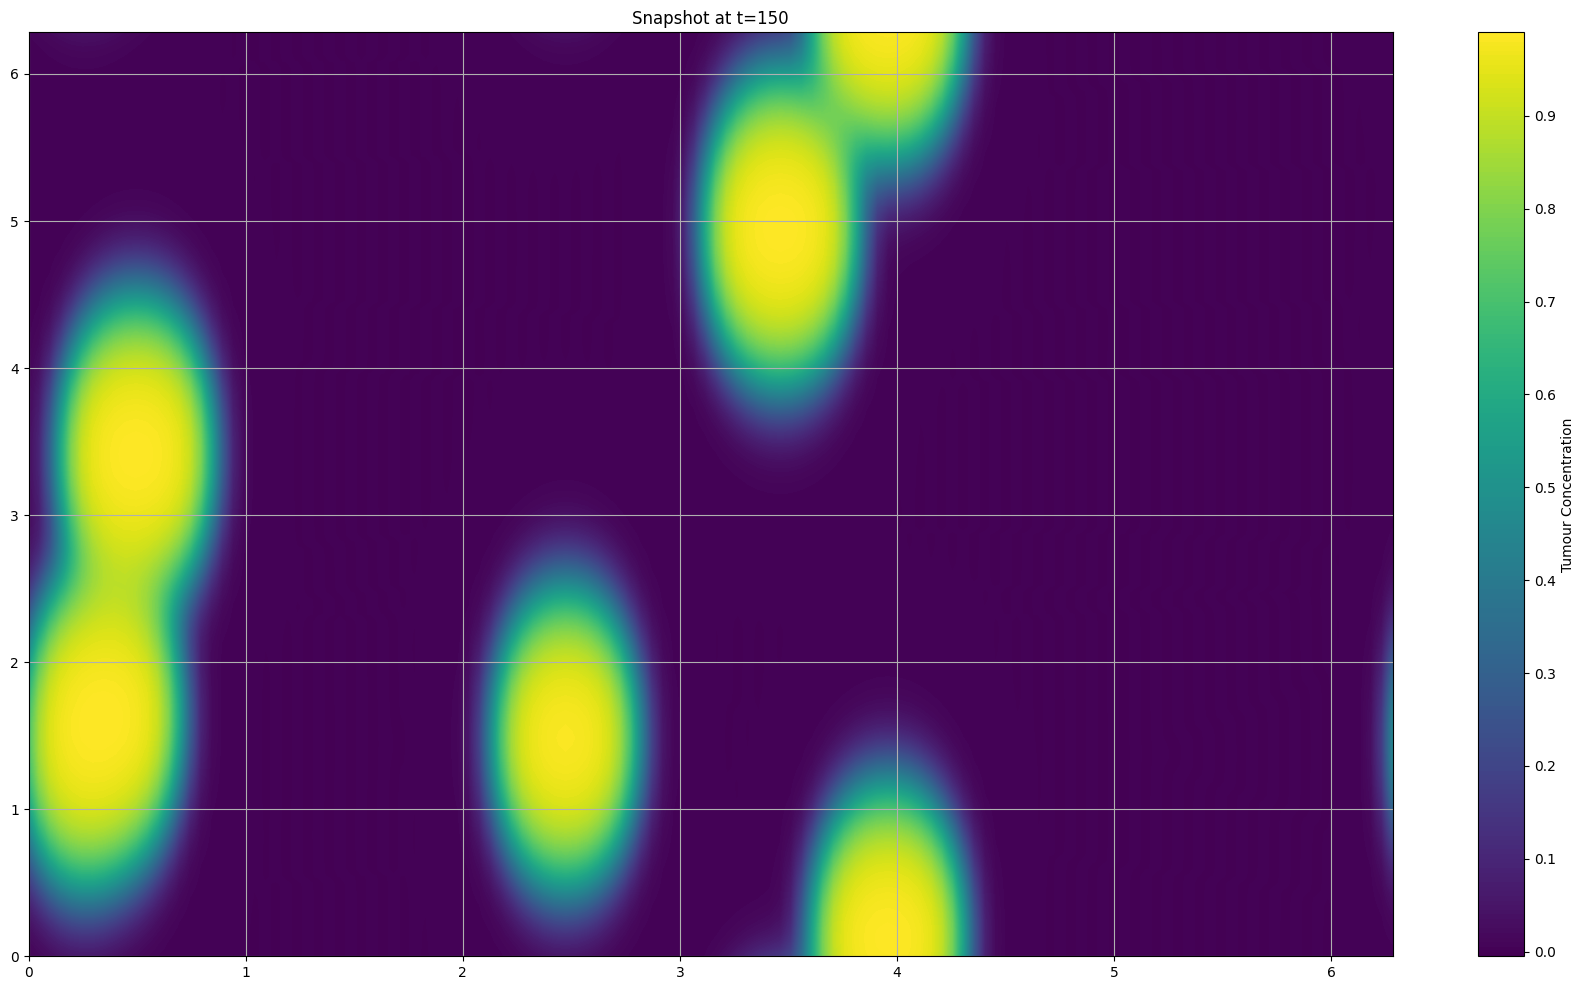

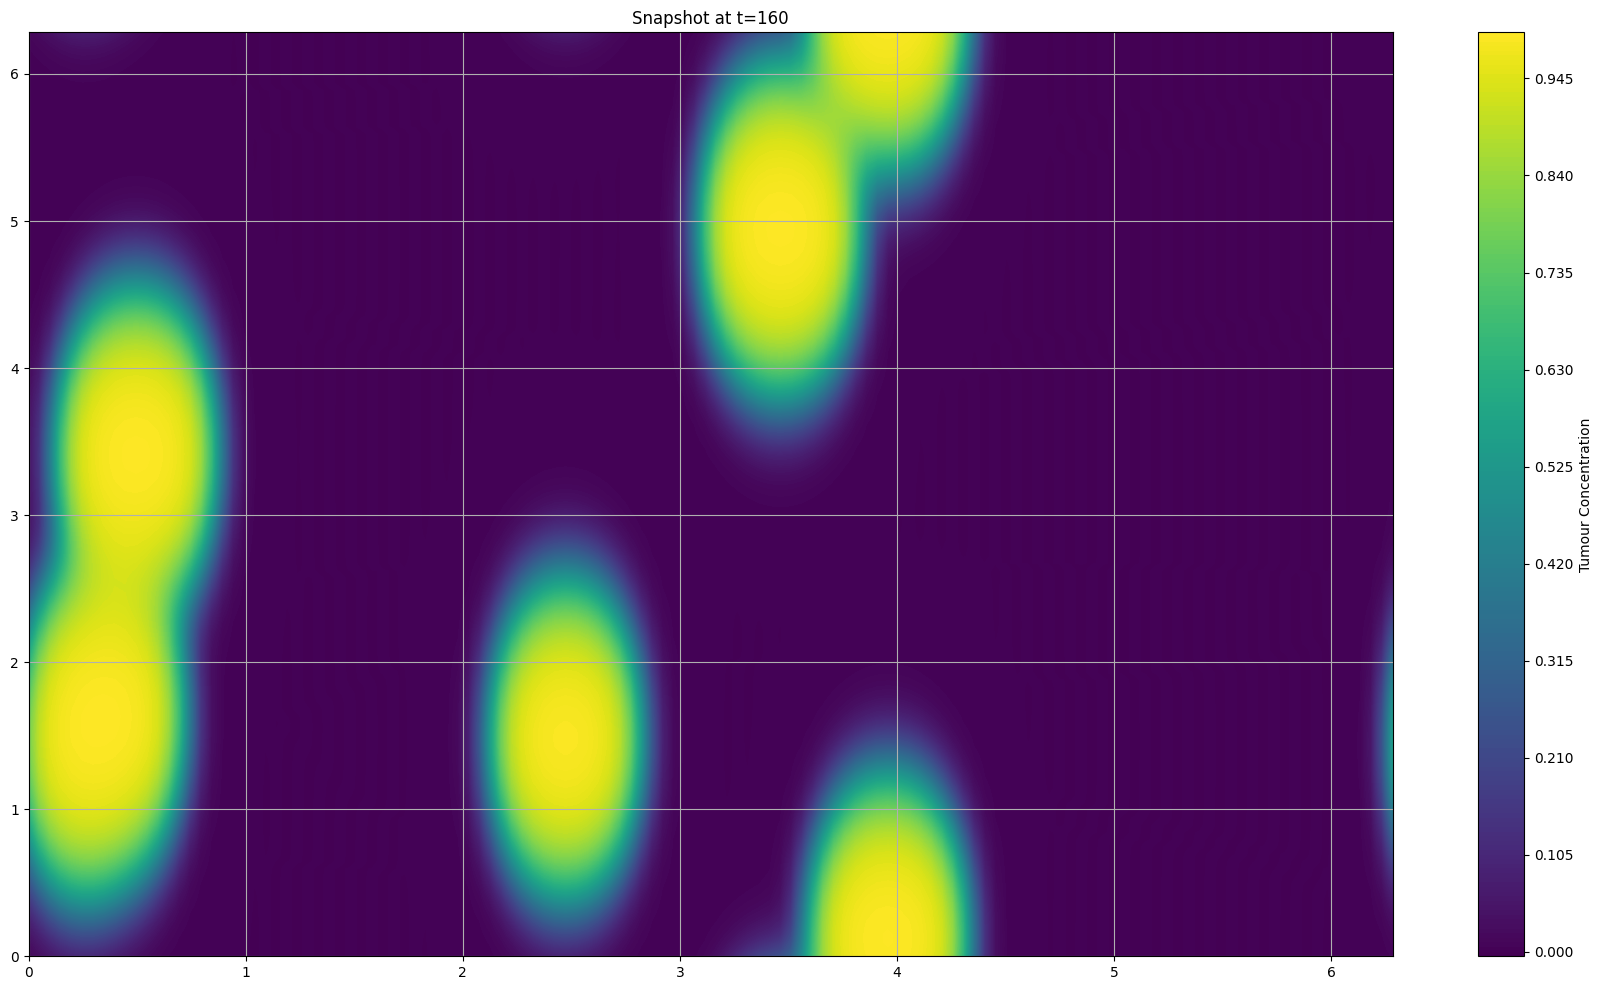

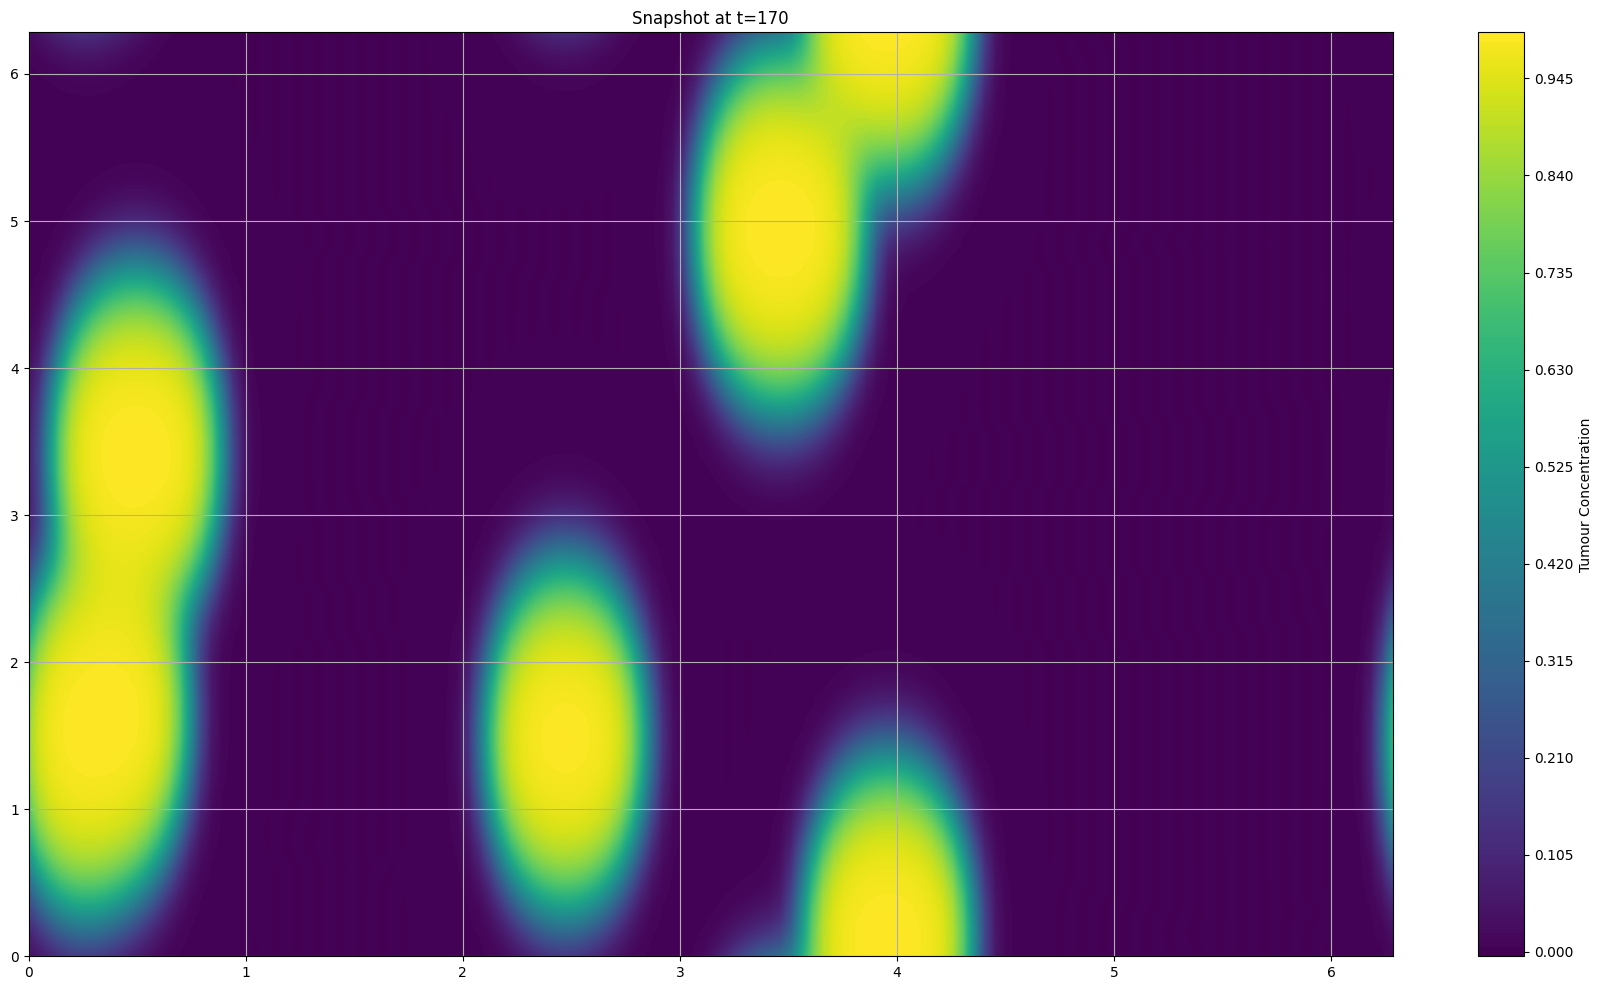

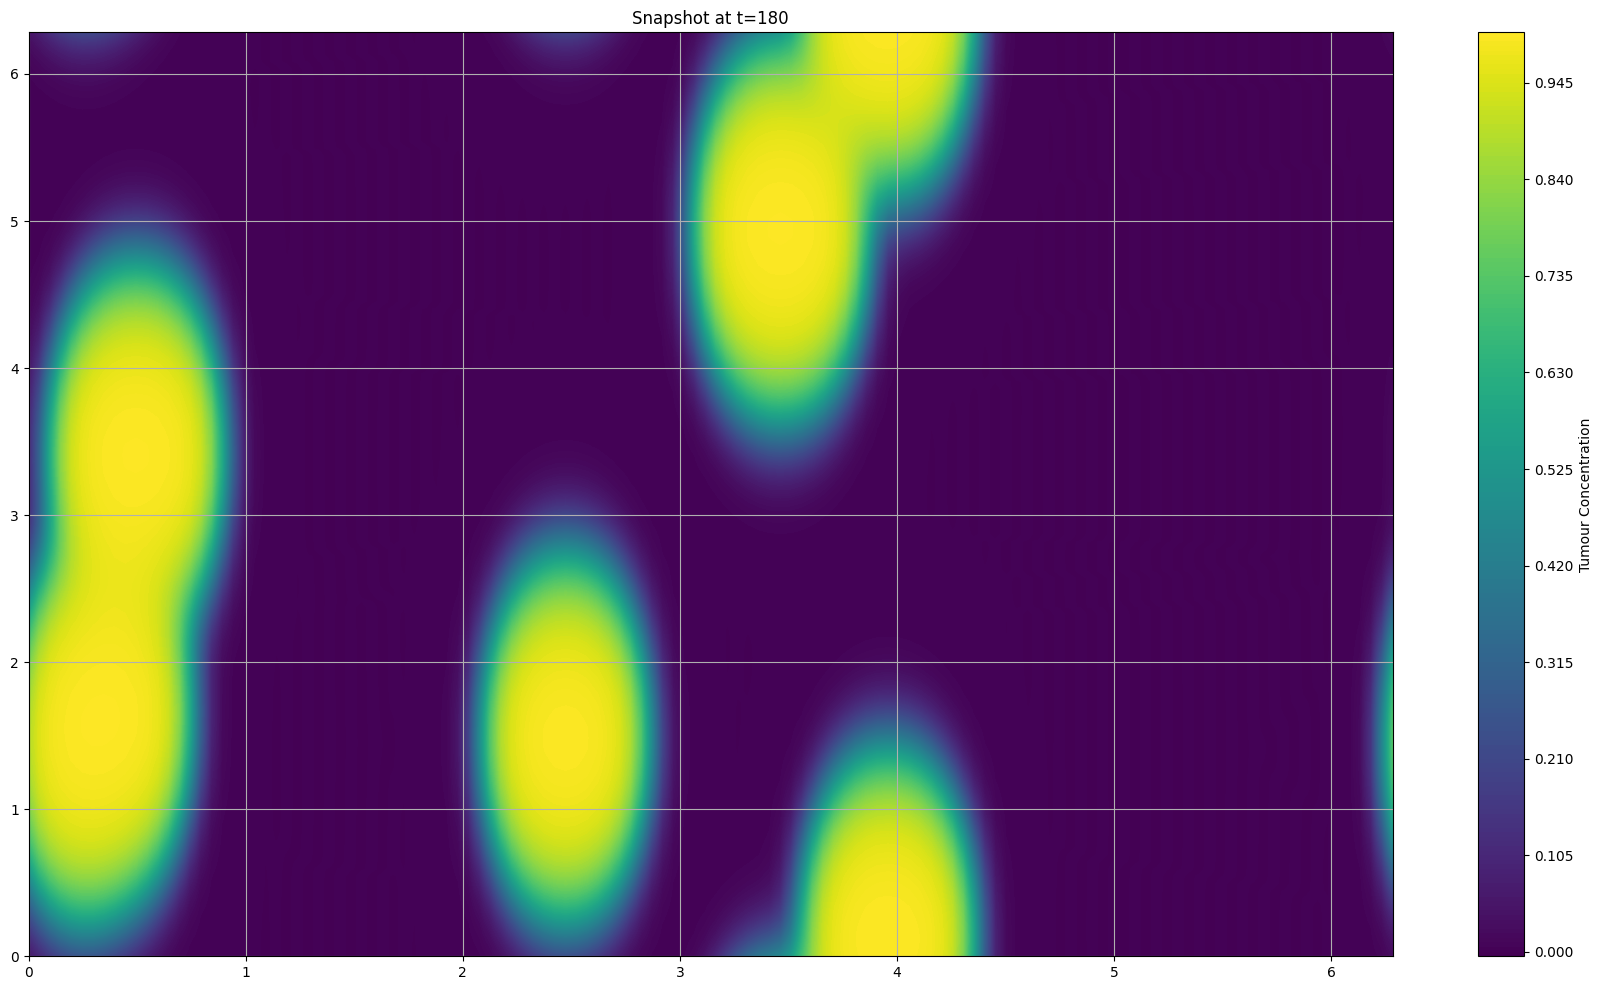

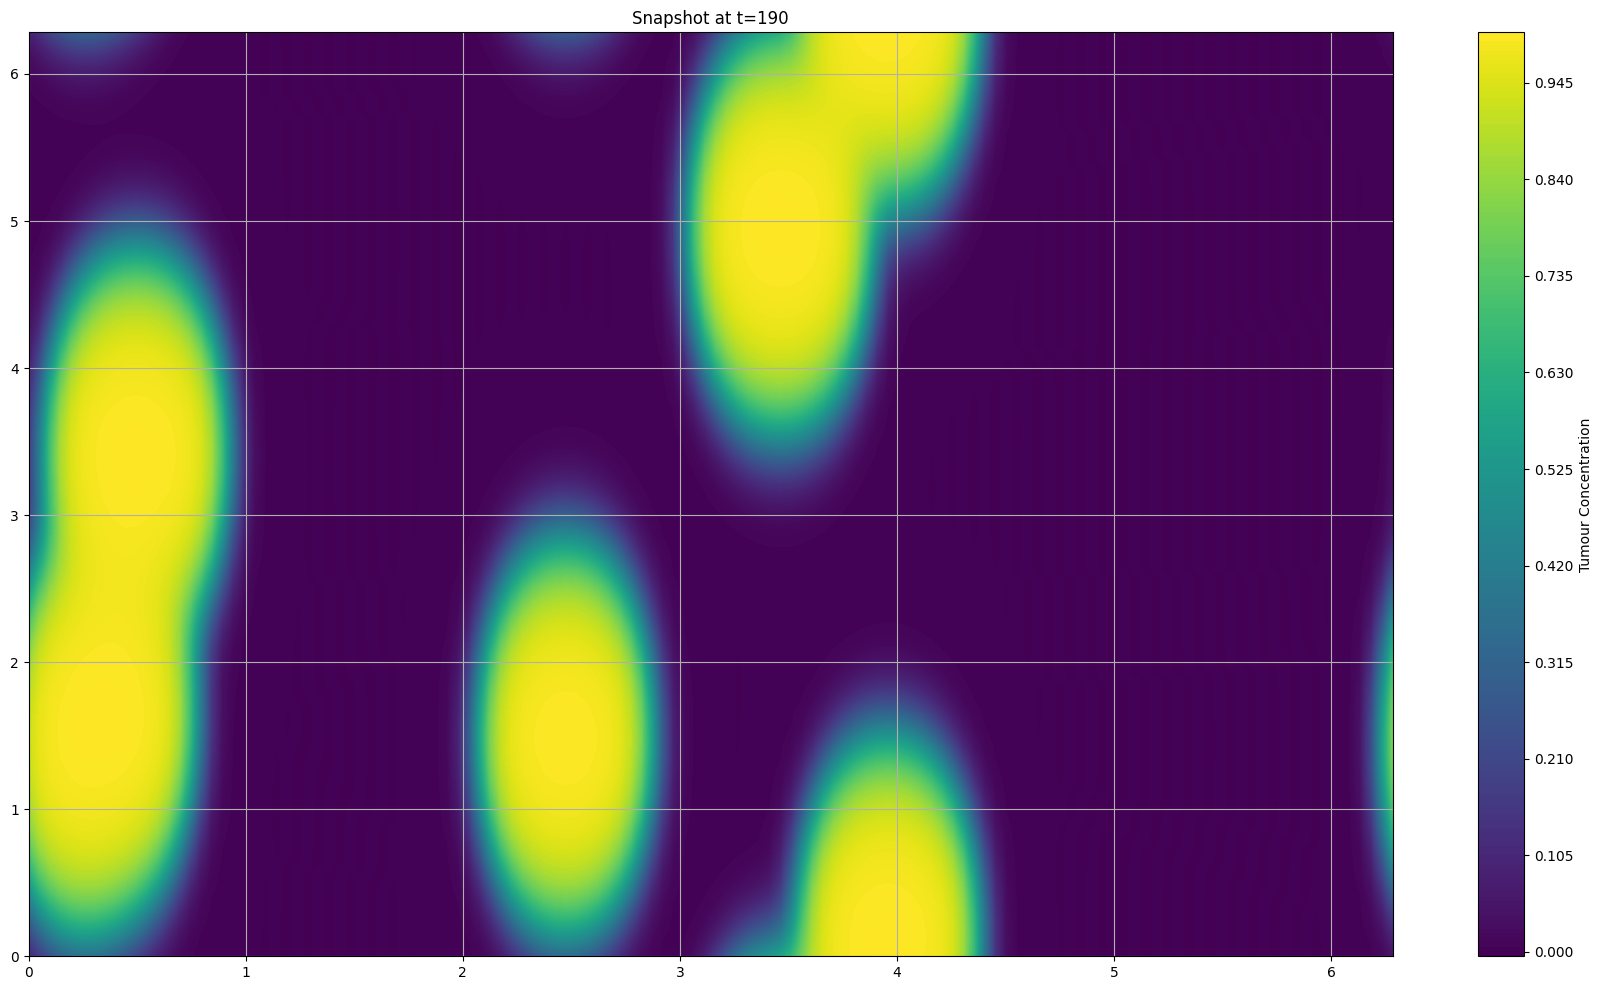

In [64]:
#Forward solver

#computing wave vectors

kx , ky = (2*np.pi)*scipy.fft.fftfreq(N_grid,d=del_grid), (2*np.pi/L)*scipy.fft.fftfreq(N_grid,d=del_grid)
kx_mesh, ky_mesh = np.meshgrid(kx,ky,indexing='ij')
k_mag = np.sqrt(kx_mesh**2 + ky_mesh**2)

N_t = 200 #number of simulation time steps
dt = 1/N_t #time discretization
print(k_true*dt)
print(rho_true * dt / 2)

#calculating Crank-Nicholsonfreq. multiplier M(k)
Mk = (1-(0.5)*k_true*dt*(k_mag**2))/(1+(0.5)*k_true*dt*(k_mag**2))
print("Mk min:" , np.min(Mk))
print("max inner term: ", np.max(0.5 * k_true * dt * (k_mag**2)))


def reaction_half_step(c_field,dt=dt,rho=3*rho_true):
        exp_term = np.exp(rho*dt/2)
        c_new = (c_field * exp_term) / (1 + c_field * (exp_term - 1))
        return c_new

def diffusion_full_step(c_field):
    c_fft = scipy.fft.fft2(c_field)
    c_bar = Mk * c_fft
    c_new = np.real(scipy.fft.ifft2(c_bar))
    return c_new

def single_iteration(c_field):
    c_field = reaction_half_step(c_field)
    c_field = diffusion_full_step(c_field)
    c_field = reaction_half_step(c_field)


    return c_field


start_state = init_cond
for n in range(N_t):
    temp = single_iteration(start_state)
    start_state = temp  # update the state for the next iteration
    if n % 10 == 0:
        plt.figure(figsize=(22, 12))
        plt.contourf(X_mesh, Y_mesh, temp, levels=200, cmap='viridis')
        plt.colorbar(label='Tumour Concentration')
        plt.grid(True)
        plt.title(f"Snapshot at t={n}")
        plt.savefig(f"Snapshot at t={n}")

     













